# Modele de CNN multihead  

In [1]:
# Package 
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
X_Y = pd.read_csv(r'C:\Users\louis\OneDrive\Documents\ENSAE\2A\Safran\X_Y.csv')

In [3]:
pretraitement = pd.read_csv(r'C:\Users\louis\OneDrive\Documents\ENSAE\2A\Safran\pretraitement.csv')

In [4]:
X_Y =X_Y.drop('Unnamed: 0', axis= 1)
pretraitement= pretraitement.drop('Unnamed: 0', axis= 1)
pretraitement.index = pretraitement['date']
del pretraitement['date']

In [5]:
X_Y

,engine_serial_number,engine_series,cycles_counter,config_A,config_B,Interpolate_var_mot_1,Interpolate_flight_leg_hours,Interpolate_SV_rank,Interpolate_WW_rank,Interpolate_Config_B_rank,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_4,Interpolate_var_env_5,id_int,Interpolate_egt_slope
0,0.101545,0.0,0.488202,0.333333,1.0,0.389301,0.041942,0.333333,8.0,0.6,0.000484,0.000383,0.519855,0.000000,0.132495,1823.0,-0.027761
1,0.101545,0.0,0.490027,0.333333,1.0,0.407359,0.054869,0.333333,8.0,0.6,0.001692,0.007238,0.551896,0.000000,0.160494,1823.0,-0.027761
2,0.101545,0.0,0.480772,0.333333,1.0,0.311815,0.057629,0.333333,8.0,0.6,0.000551,0.001096,0.482353,0.333333,0.198413,1823.0,-0.027761
3,0.101545,0.0,0.480511,0.333333,1.0,0.307892,0.051835,0.333333,8.0,0.6,0.000540,0.002214,0.491232,0.000000,0.181941,1823.0,-0.027761
4,0.101545,0.0,0.479729,0.333333,1.0,0.293103,0.044069,0.333333,8.0,0.6,0.000985,0.000383,0.469181,0.000000,0.184318,1823.0,-0.027761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661595,0.000000,0.0,0.063486,0.000000,0.0,0.568451,0.037881,0.000000,0.0,0.0,0.000623,0.028264,0.541176,0.000000,0.103175,8438.0,-0.029193
661596,0.000000,0.0,0.153826,0.000000,0.0,0.546965,0.033642,0.000000,0.0,0.0,0.027012,0.006616,0.376471,0.000000,0.172619,8438.0,-0.029193
661597,0.000000,0.0,0.131274,0.000000,0.0,0.374079,0.104182,0.000000,0.0,0.0,0.003318,0.008737,0.541176,0.000000,0.109127,8438.0,-0.029193
661598,0.000000,0.0,0.087994,0.000000,0.0,0.532420,0.054073,0.000000,0.0,0.0,0.196857,0.028143,0.505882,0.333333,0.162698,8438.0,-0.029193


## Prétraitement des variables environnementales

A partir de ce dataframe, on souhaite décomposer les séries des variables environnementales en 3 séries :
- tendance 
- saisonnalité 
- bruit 

afin de les intégrer dans différentes branches du réseau de neurones. 

Pour cela il faut trouver une période de temps ou une fréquence, sur laquelle les événements se répétent. 

Pour exemple, on affiche le graphique représentant la série var_env_1 pour deux moteurs (ESN_3 et ESN_45) sur leurs 200 premiers vols  : 

<AxesSubplot:xlabel='date'>

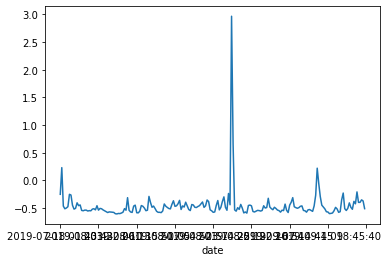

In [6]:
pretraitement[pretraitement.engine_serial_number=="ESN_3"].head(200)['Interpolate_var_env_1'].plot()

<AxesSubplot:xlabel='date'>

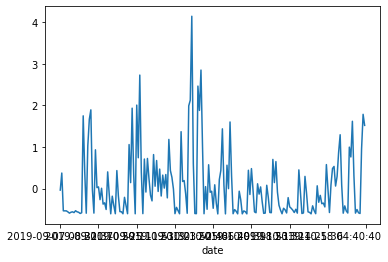

In [7]:
pretraitement[pretraitement.engine_serial_number=="ESN_45"].head(200)['Interpolate_var_env_1'].plot()

On remarque tout d'abord que les séries sont très différentes d'un moteur à l'autre. 

Analysons ces séries sur les intervalles de 100 vols choisis précedemment. 

In [8]:
# On décompose le dataframe complet en 6 616 échantillons de 100 vols :
dfs = np.array_split(X_Y[['Interpolate_var_env_1','Interpolate_var_env_2', 'Interpolate_var_env_3', 'Interpolate_var_env_4', 'Interpolate_var_env_5', 'id_int']], 6616)

# Affichage d'un échantillon : 
dfs[50]

,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_4,Interpolate_var_env_5,id_int
5000,0.002859,0.008401,0.658824,0.0,0.168651,1873.0
5001,0.005533,0.008206,0.694118,0.0,0.142857,1873.0
5002,0.000904,0.055761,0.576471,0.0,0.156746,1873.0
5003,0.010270,0.080571,0.635294,0.0,0.111111,1873.0
5004,0.002660,0.025640,0.623529,0.0,0.188492,1873.0
...,...,...,...,...,...,...
5095,0.004392,0.030277,0.658824,0.0,0.188492,1873.0
5096,0.002161,0.080571,0.564706,0.0,0.166667,1873.0
5097,0.000048,0.080571,0.576471,0.0,0.130952,1873.0
5098,0.001840,0.053393,0.729412,0.0,0.081349,1873.0


Comme précedemment, on compare les graphiques de différents échantillons : 

<AxesSubplot:>

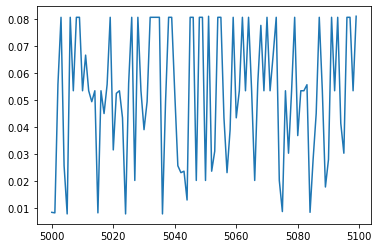

In [9]:
dfs[50].Interpolate_var_env_2.plot()

<AxesSubplot:>

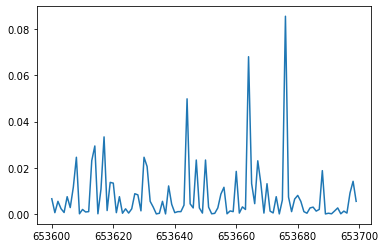

In [10]:
dfs[6536].Interpolate_var_env_2.plot()

Les graphiques sont très différents entre deux échantillons, pour une même variable environnementale. Il sera donc difficile de trouver une tendance et une saisonalité commune à tous les échantillons

Analysons les corrélations entre les différentes variables environnementales :

<AxesSubplot:>

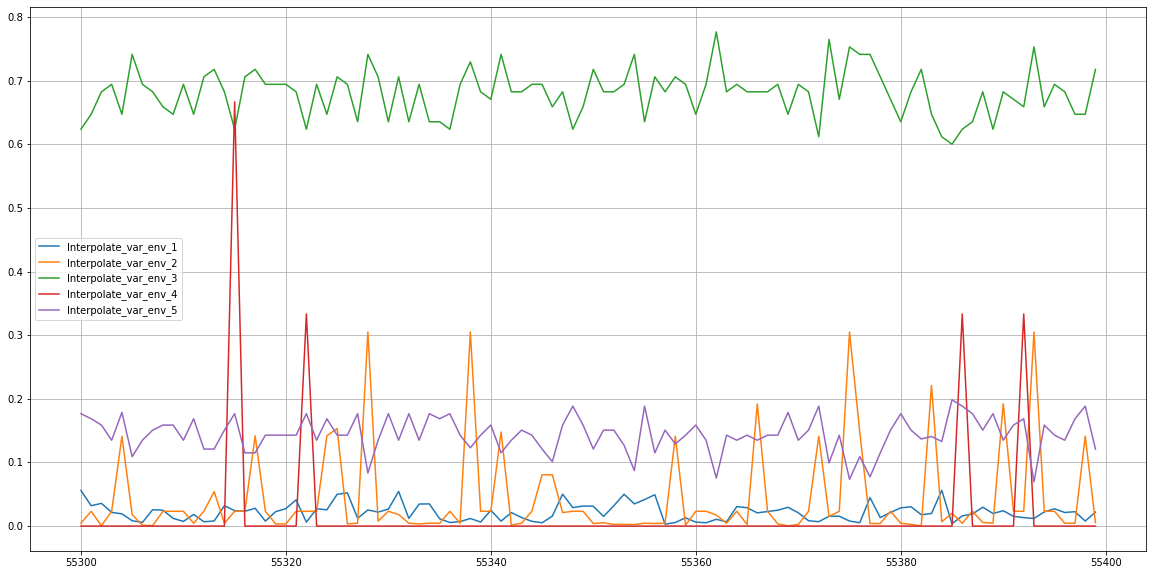

In [11]:
# Exemple pour l'échantillon 553 : 
dfs[553].plot( y=['Interpolate_var_env_1', 'Interpolate_var_env_2','Interpolate_var_env_3','Interpolate_var_env_4', 'Interpolate_var_env_5'], figsize=(20,10), grid=True)

Ce n'est pas impossible qu'il y ait une corrélation entre ces variables.

In [12]:
dfs[553].corr()

,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_4,Interpolate_var_env_5,id_int
Interpolate_var_env_1,1.000000,-0.191347,-0.055728,-0.071533,0.020022,NaN
Interpolate_var_env_2,-0.191347,1.000000,0.274827,-0.062906,-0.351021,NaN
Interpolate_var_env_3,-0.055728,0.274827,1.000000,-0.258630,-0.892466,NaN
Interpolate_var_env_4,-0.071533,-0.062906,-0.258630,1.000000,0.233310,NaN
Interpolate_var_env_5,0.020022,-0.351021,-0.892466,0.233310,1.000000,NaN
id_int,NaN,NaN,NaN,NaN,NaN,NaN


Pour cet échantillon, il semblerait que les variables environnementales 3 et 5 soient négativement corrélées.

Analysons les corrélations de ces variables dans la base initiale 

In [13]:
pretraitement[['Interpolate_var_env_1', 'Interpolate_var_env_2','Interpolate_var_env_3', 'Interpolate_var_env_4', 'Interpolate_var_env_5']].corr()

,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_4,Interpolate_var_env_5
Interpolate_var_env_1,1.000000,0.021848,0.019692,0.066995,0.110219
Interpolate_var_env_2,0.021848,1.000000,0.182493,-0.001482,-0.169041
Interpolate_var_env_3,0.019692,0.182493,1.000000,-0.068075,-0.311830
Interpolate_var_env_4,0.066995,-0.001482,-0.068075,1.000000,0.217841
Interpolate_var_env_5,0.110219,-0.169041,-0.311830,0.217841,1.000000


Les variables sont corrélées, pour certaines très faiblement.

Il est donc incertain que les séries des variables environnementales aient les mêmes propriétés de saisonnalité ou de tendance. Cependant, par soucis de temps et pour simplifier nos calculs nous ne chercherons pas à différencier les propriétés des différentes variables environnementales.

Nous cherchons à trouver la fréquence (unique pour toutes les variables environnementales) qui optimise les résultats du modèle 

In [14]:
def decompose_serie (serie, frequence ):
    '''
    Cette fonction permet de décomposer une série (composée de plusieurs échantillons) en fonction de la fréquence
    passée en paramètre. Elle renvoie la série décomposée en tendance, saisonnalité et bruit 
    
    Exemple :
    decompose_serie (dfs, 6 ) : décompose la série dfs, composée de 6 616, en 3 dataframe : la tendance, la saisonnalité,
    le bruit. 
    
    
    
    '''
    df_trend = pd.DataFrame(columns=['Var_1_trend','Var_2_trend','Var_3_trend','Var_4_trend' , 'Var_5_trend', 'id_int'])
    df_season = pd.DataFrame(columns=['Var_1_season','Var_2_season','Var_3_season','Var_4_season' , 'Var_5_season', 'id_int'])
    df_resid = pd.DataFrame(columns=['Var_1_resid','Var_2_resid','Var_3_resid','Var_4_resid' , 'Var_5_resid', 'id_int'])

    for i in range(len(serie)) :
        result_1 = seasonal_decompose(serie[i]['Interpolate_var_env_1'], model='additive', freq=frequence)
        result_2 = seasonal_decompose(serie[i]['Interpolate_var_env_2'], model='additive', freq=frequence)
        result_3 = seasonal_decompose(serie[i]['Interpolate_var_env_3'], model='additive', freq=frequence)
        result_4 = seasonal_decompose(serie[i]['Interpolate_var_env_4'], model='additive', freq=frequence)
        result_5 = seasonal_decompose(serie[i]['Interpolate_var_env_5'], model='additive', freq=frequence)

        df_trend_i= pd.DataFrame({'Var_1_trend': result_1.trend ,'Var_2_trend' : result_2.trend,'Var_3_trend':result_3.trend,'Var_4_trend': result_4.trend, 'Var_5_trend':result_5.trend, 'id_int': dfs[i].id_int})
        df_trend_i= df_trend_i.fillna(df_trend_i.ffill())
        df_trend_i= df_trend_i.fillna(df_trend_i.bfill())
        df_trend = pd.concat([df_trend,df_trend_i])

        df_season_i= pd.DataFrame({'Var_1_season': result_1.seasonal ,'Var_2_season' : result_2.seasonal,'Var_3_season':result_3.seasonal,'Var_4_season': result_4.seasonal, 'Var_5_season':result_5.seasonal, 'id_int': dfs[i].id_int})
        df_season = pd.concat([df_season,df_season_i])

        df_resid_i= pd.DataFrame({'Var_1_resid': result_1.resid,'Var_2_resid' : result_2.resid,'Var_3_resid':result_3.resid,'Var_4_resid': result_4.resid, 'Var_5_resid':result_5.resid, 'id_int': dfs[i].id_int})
        df_resid_i= df_resid_i.fillna(df_resid_i.ffill())
        df_resid_i= df_resid_i.fillna(df_resid_i.bfill())
        df_resid = pd.concat([df_resid,df_resid_i])

        if i == int(len(serie)/4):
            print("25% du traitement effectué")
        if i == int(len(serie)/2):
            print("50% du traitement effectué")
        if i == int(len(serie) *(3/4)):
            print("75% du traitement effectué")
        if i == int(len(serie)-1):
            print("Terminé ! ")
    return df_trend, df_season, df_resid

In [15]:
# Temps de traitement autour de 5 minutes
df_trend, df_season, df_resid = decompose_serie (dfs, 15 )

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead


25% du traitement effectué
50% du traitement effectué
75% du traitement effectué
Terminé ! 


In [16]:
# On introduit le dataframe correspondant aux autres variables (hors environnementales) à prendre en compte
df_complement = X_Y[['engine_serial_number', 'engine_series', 'cycles_counter', 'config_A',
       'config_B', 'Interpolate_var_mot_1', 'Interpolate_flight_leg_hours',
       'Interpolate_SV_rank', 'Interpolate_WW_rank','Interpolate_Config_B_rank','Interpolate_egt_slope']]

On traite nos dataframes pour qu'ils puissent entrer dans le modèle. 

On souhaite couper ce dataframe en échantillon de taille 100, où à chaque échantillon correspond une valeur de pente pour la marge EGT. 

In [17]:
def split_sequences_X_Y(sequences, n_steps) : 
    '''
    Découpage d'un dataframe correspondant aux variables X et Y, en échantillon de taille n_steps
    '''
    X, y = list(), list()
    n_iteration = int(len(sequences)/n_steps)
    if len(sequences)%n_steps != 0 : 
        print("Attention, modulo différent de zero")
    for i in range(n_iteration): 
        seq_x, seq_y = sequences [i*n_steps :(i+1)*n_steps, :-1 ], sequences[i*n_steps ,-1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)    

In [18]:
X_complement, y = split_sequences_X_Y(df_complement.values, 100)

In [19]:
def split_sequences_X(sequences, n_steps) : 
    '''
    Découpage d'un dataframe correspondant aux variables X en échantillon de taille n_steps
    '''
    X= list()
    n_iteration = int(len(sequences)/n_steps)
    if len(sequences)%n_steps != 0 : 
        print("Attention, modulo différent de zero")
    for i in range(n_iteration): 
        seq_x = sequences [i*n_steps :(i+1)*n_steps,:-1]
        X.append(seq_x)
    return array(X)

In [20]:
X_trend, X_season, X_resid =  split_sequences_X(df_trend.values, 100), split_sequences_X(df_season.values, 100), split_sequences_X(df_resid.values, 100)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_complement_train, X_complement_test, X_trend_train , X_trend_test, X_season_train, X_season_test, X_resid_train, X_resid_test, Y_train, Y_test = train_test_split(X_complement,X_trend,X_season,X_resid, y, test_size = 0.2, random_state=42)

## Le modèle 

In [140]:
# Importation des packages de deep learning 
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential 
from tensorflow.keras.layers import (Conv1D, Dense,Dropout, Flatten,MaxPooling1D, concatenate)

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import Input
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [141]:
# Importation des packages de deep learning 
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential 
from keras.layers.core import (Dense,Dropout, Flatten)
from keras.layers.convolutional import Conv1D, MaxPooling1D, SeparableConv2D
from keras.layers import  concatenate

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import Input
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [142]:
# first input model
visible1 = Input(shape=(100, 10))
cnn1 = Conv1D(filters=64, kernel_size=2, activation='tanh',padding='same')(visible1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Flatten()(cnn1)

In [143]:
visible2 = Input(shape=(100, 5))
cnn2 = Conv1D(filters=64, kernel_size=2, activation='tanh', padding='same')(visible2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)

In [144]:
visible3 = Input(shape=(100, 5))
cnn3 = Conv1D(filters=64, kernel_size=2, activation='tanh',padding='same')(visible3)
cnn3 = MaxPooling1D(pool_size=2)(cnn3)
cnn3 = Flatten()(cnn3)

In [145]:
visible4 = Input(shape=(100, 5))
cnn4 = Conv1D(filters=64, kernel_size=2, activation='tanh', padding='same')(visible4)
cnn4 = MaxPooling1D(pool_size=2)(cnn4)
cnn4 = Flatten()(cnn4)

In [146]:
# merge input models
merge = concatenate([cnn1, cnn2, cnn3, cnn4])
dense = Dense(20)(merge)
output = Dense(1,activation='tanh')(dense)

In [147]:
model = Model(inputs=[visible1, visible2,visible3,visible4 ], outputs=output)

In [148]:
model.compile(optimizer='adam', loss='mse')

In [149]:
# La condition suivante permet d'arrêter l'entrainement si le modéle n'apprend pas pendant 5 périodes : 
earlystop = EarlyStopping(patience=5) 
callbacks = [earlystop]

In [150]:
history= model.fit([X_complement_train, X_trend_train, X_season_train, X_resid_train], Y_train, epochs=10, validation_split = 0.2)

Epoch 1/10
133/133 [==============================] - 1s 8ms/step - loss: 0.9743 - val_loss: 0.9401
Epoch 2/10
133/133 [==============================] - 1s 6ms/step - loss: 0.9801 - val_loss: 0.9401
Epoch 3/10
133/133 [==============================] - 1s 7ms/step - loss: 0.9801 - val_loss: 0.9400
Epoch 4/10
133/133 [==============================] - 1s 7ms/step - loss: 0.9706 - val_loss: 0.9401
Epoch 5/10
133/133 [==============================] - 1s 7ms/step - loss: 0.9801 - val_loss: 0.9401
Epoch 6/10
133/133 [==============================] - 1s 7ms/step - loss: 0.9801 - val_loss: 0.9401
Epoch 7/10
133/133 [==============================] - 1s 7ms/step - loss: 0.9801 - val_loss: 0.9401
Epoch 8/10
133/133 [==============================] - 1s 7ms/step - loss: 0.9801 - val_loss: 0.9401
Epoch 9/10
133/133 [==============================] - 1s 6ms/step - loss: 0.9801 - val_loss: 0.9401
Epoch 10/10
133/133 [==============================] - 1s 8ms/step - loss: 0.9801 - val_loss: 0.9401

In [151]:
test_loss = model.evaluate([X_complement_test, X_trend_test, X_season_test, X_resid_test], Y_test)

42/42 [==============================] - 0s 5ms/step - loss: 0.9606


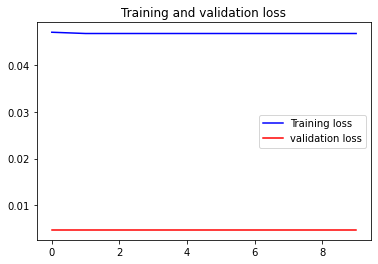

In [131]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.title('Training and validation loss')

legend = plt.legend()
plt.show()

In [132]:
preds = model.predict([X_complement_test, X_trend_test, X_season_test, X_resid_test])

In [133]:
preds

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

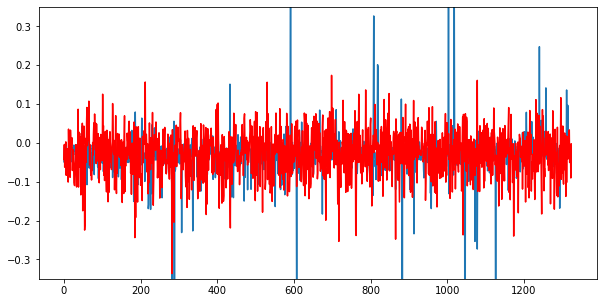

In [119]:
from matplotlib import pyplot
pyplot.figure(figsize=(10,5))
pyplot.plot(Y_test)
plt.ylim(-0.35,0.35)
pyplot.plot(preds, 'r')
pyplot.show()

In [ ]:
# X_complement_train, X_complement_test, X_trend_train , X_trend_test, X_season_train, X_season_test, X_resid_train, X_resid_test, Y_train, Y_test = train_test_split(X_complement,X_trend,X_season,X_resid, y, test_size = 0.2, random_state=42)

In [876]:
choix_frequence(dfs, [5,10])

Epoch 1/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0435 - val_loss: 0.0037
Epoch 2/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0435 - val_loss: 0.0037
Epoch 3/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0435 - val_loss: 0.0037
Epoch 4/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0435 - val_loss: 0.0037
Epoch 5/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0435 - val_loss: 0.0037
Epoch 6/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0435 - val_loss: 0.0037
Epoch 7/20
133/133 [==============================] - 1s 7ms/step - loss: 0.0435 - val_loss: 0.0037
Epoch 8/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0435 - val_loss: 0.0037
Epoch 9/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0435 - val_loss: 0.0037
oko


In [902]:
def choix_frequence (serie, frequences) : 
    '''
    Fonction qui teste le modèle pour différentes fréquences passées en paramètre. 
    Attention, cette fonction met un certain temps à s'effectuer : proportionnel à la taille de la série et au nombre de 
    fréquences à tester.
    Elle renvoie un dataframe comprenant les différentes fréquences associées à la loss sur la base de test. 
    '''
    df_result_freq = pd.DataFrame(columns=['Frequence','Var_2_trend'])
    for frequence in frequences : 
        print("En cours de traitement de la fréquence : ", frequence)
        df_trend, df_season, df_resid = decompose_serie (serie, frequence)
        X_trend, X_season, X_resid =  split_sequences_X(df_trend.values, 100), split_sequences_X(df_season.values, 100), split_sequences_X(df_resid.values, 100)
        (X_complement_train, X_complement_test, X_trend_train , X_trend_test, X_season_train, X_season_test, X_resid_train, X_resid_test, Y_train, Y_test) = train_test_split(X_complement,X_trend,X_season,X_resid, y, test_size = 0.2)
        history= model.fit([X_complement_train, X_trend_train, X_season_train, X_resid_train], Y_train, epochs=20, validation_split = 0.2, callbacks=callbacks)
        test_loss = model.evaluate([X_complement_test, X_trend_test, X_season_test, X_resid_test], Y_test)
        df_result_freq_i = pd.DataFrame({'Frequence': [frequence] ,'Var_2_trend' : [test_loss]})
        df_result_freq = pd.concat([df_result_freq,df_result_freq_i])
    return df_result_freq

In [903]:
df_result_freq = choix_frequence (dfs, [1,5,10,15,20,25,30,35,40,45,50])

En cours de traitement de la fréquence :  1


C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  if __name__ == '__main__':
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  # This is added back by InteractiveShellApp.init_path()


25% du traitement effectué
50% du traitement effectué
75% du traitement effectué
Terminé ! 
Epoch 1/20
133/133 [==============================] - 1s 7ms/step - loss: 0.0268 - val_loss: 0.0021
Epoch 2/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0268 - val_loss: 0.0020
Epoch 3/20
133/133 [==============================] - 1s 9ms/step - loss: 0.0268 - val_loss: 0.0020
Epoch 4/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0268 - val_loss: 0.0020
Epoch 5/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0268 - val_loss: 0.0020
Epoch 6/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0268 - val_loss: 0.0021
Epoch 7/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0268 - val_loss: 0.0020
Epoch 8/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0268 - val_loss: 0.0021
Epoch 9/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0268 - val_loss: 0.0020
Epoch 10

In [904]:
df_result_freq

,Frequence,Loss,Var_2_trend
0,1,NaN,0.093775
0,5,NaN,0.022926
0,10,NaN,0.021899
0,15,NaN,0.003528
0,20,NaN,0.014393
0,25,NaN,0.102117
0,30,NaN,0.006719
0,35,NaN,0.011503
0,40,NaN,0.033328
0,45,NaN,0.028298


In [409]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(100, X_complement_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [410]:
history = model.fit(X_complement_train, Y_train, epochs=10, validation_split = 0.2)

Epoch 1/10
133/133 [==============================] - 0s 3ms/step - loss: 0.1153 - val_loss: 0.0041
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0038
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0037
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0037
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0036
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0036
Epoch 7/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0037
Epoch 8/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0035
Epoch 9/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0036
Epoch 10/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0036

In [414]:
X_complement_train.shape

(5292, 100, 10)

In [415]:
x_input = X_complement_train[0]
x_input = x_input.reshape((1, 100, 10))

In [416]:
x_input

array([[[0.04709345, 0.        , 0.20949029, 0.        , 1.        ,
         0.13685721, 0.13613258, 0.        , 2.        , 0.4       ],
        [0.04709345, 0.        , 0.19853996, 0.        , 1.        ,
         0.03921577, 0.21276349, 0.        , 2.        , 0.4       ],
        [0.04709345, 0.        , 0.20088646, 0.        , 1.        ,
         0.41974892, 0.26635718, 0.        , 2.        , 0.4       ],
        [0.04709345, 0.        , 0.19176118, 0.        , 1.        ,
         0.50566374, 0.15295494, 0.        , 2.        , 0.4       ],
        [0.04709345, 0.        , 0.20023465, 0.        , 1.        ,
         0.53477565, 0.20223274, 0.        , 2.        , 0.4       ],
        [0.04709345, 0.        , 0.20440621, 0.        , 1.        ,
         0.46138206, 0.12976427, 0.        , 2.        , 0.4       ],
        [0.04709345, 0.        , 0.18589493, 0.        , 1.        ,
         0.48140485, 0.19576851, 0.        , 2.        , 0.4       ],
        [0.04709345, 0.    

In [417]:
model.predict(x_input)

array([[-0.03070463]], dtype=float32)

In [418]:
Y_train[0]

-0.06207703

In [94]:
x_input = X_train[0:3]

In [95]:
x_input
x_input = x_input.reshape((3, 100, 15))

In [96]:
model.predict(x_input)

array([[ 0.30618152],
       [-0.5657972 ],
       [ 0.09630451]], dtype=float32)

In [97]:
model.predict(X_train[0:3])

array([[ 0.30618152],
       [-0.5657972 ],
       [ 0.09630451]], dtype=float32)